Loading FastText model with Gensim...
Extracting embeddings...


100%|██████████| 15000/15000 [00:08<00:00, 1819.88it/s]


Saved embeddings and labels to /Users/socheata/Documents/FYP-Khmer-Classification/FastText_Features
Visualizing embeddings with PCA...


/var/folders/9n/ttnnmpy11wb3xzbvs4djr1yr0000gn/T/ipykernel_1946/2285013275.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(categories))


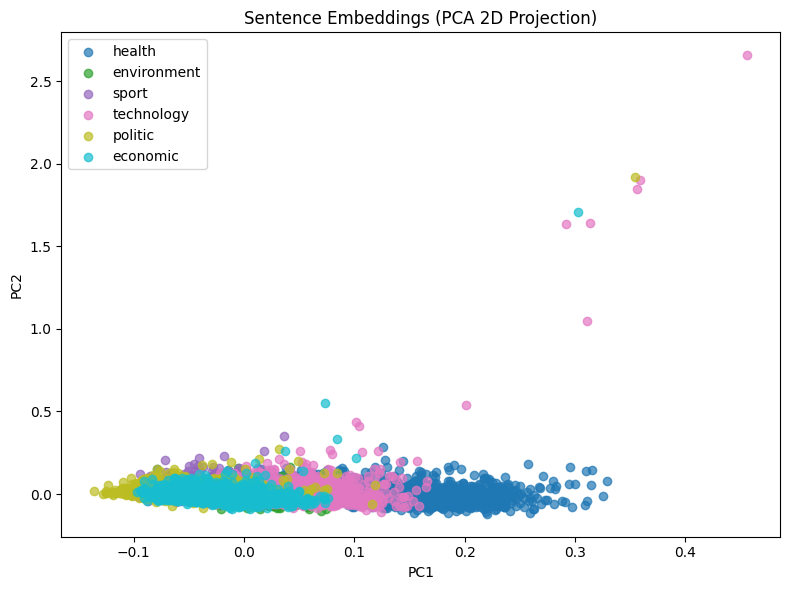

Visualizing embeddings with t-SNE...


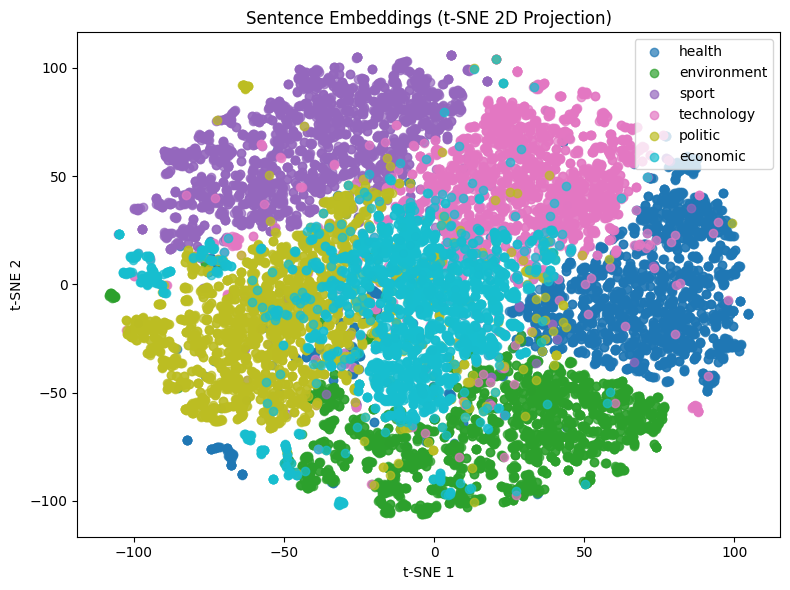

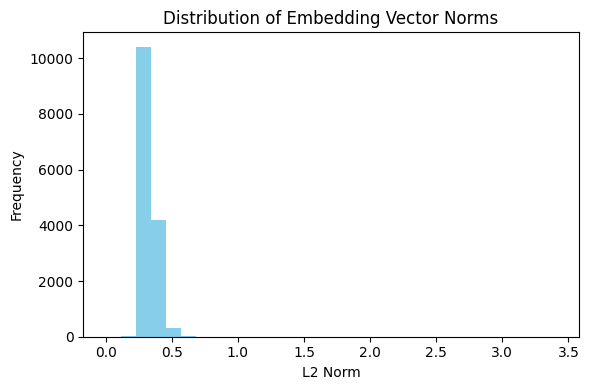

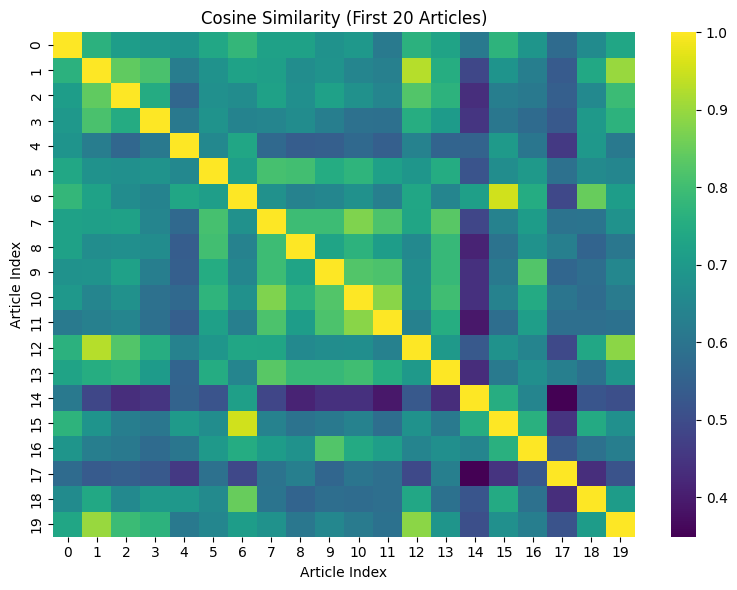

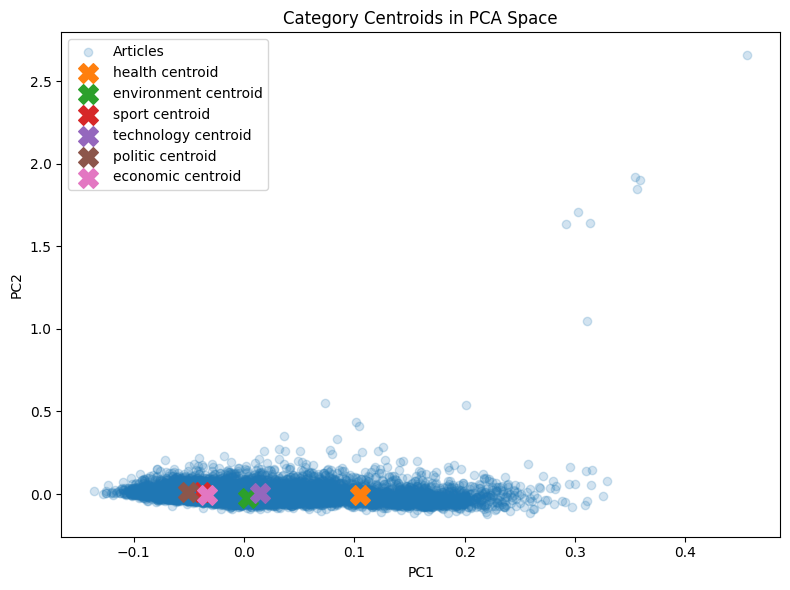

In [3]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from gensim.models.fasttext import load_facebook_model

# Output directory
OUTPUT_DIR = "/Users/socheata/Documents/FYP-Khmer-Classification/FastText_Features"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Paths
METADATA_PATH = "/Users/socheata/Documents/FYP-Khmer-Classification/original_articles/metadata.csv"
ARTICLES_DIR = "../../Preprocess_articles"
MODEL_PATH = "cc.km.300.bin"  # Update if your model is elsewhere

# Load metadata
df = pd.read_csv(METADATA_PATH)

# Load FastText model using Gensim
print("Loading FastText model with Gensim...")
ft = load_facebook_model(MODEL_PATH)

def get_article_text(doc_id):
    file_path = os.path.join(ARTICLES_DIR, f"{doc_id}.txt")
    if not os.path.exists(file_path):
        print(f"Warning: {file_path} not found.")
        return ""
    with open(file_path, "r", encoding="utf-8") as f:
        return f.read()

def get_sentence_embedding(text):
    words = text.strip().split()
    if not words:
        return np.zeros(ft.vector_size)
    vectors = [ft.wv[word] for word in words if word in ft.wv]
    if not vectors:
        return np.zeros(ft.vector_size)
    return np.mean(vectors, axis=0)

embeddings = []
doc_ids = []

print("Extracting embeddings...")
for _, row in tqdm(df.iterrows(), total=len(df)):
    doc_id = row['docId']
    text = get_article_text(doc_id)
    emb = get_sentence_embedding(text)
    embeddings.append(emb)
    doc_ids.append(doc_id)

embeddings = np.vstack(embeddings)

# Save as numpy array and CSV with docId
np.save(os.path.join(OUTPUT_DIR, "sentence_embeddings.npy"), embeddings)
pd.DataFrame(embeddings, index=doc_ids).to_csv(os.path.join(OUTPUT_DIR, "sentence_embeddings.csv"))

# Save labels (categories) in the same order as embeddings
labels = df.set_index('docId').loc[doc_ids]['category'].values
np.save(os.path.join(OUTPUT_DIR, "labels.npy"), labels)
pd.DataFrame({'docId': doc_ids, 'category': labels}).to_csv(os.path.join(OUTPUT_DIR, "labels.csv"), index=False)

print(f"Saved embeddings and labels to {OUTPUT_DIR}")

# Visualization
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# --- PCA Visualization (already present) ---
print("Visualizing embeddings with PCA...")
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
categories = list(set(labels))
colors = plt.cm.get_cmap('tab10', len(categories))

for idx, cat in enumerate(categories):
    inds = [i for i, l in enumerate(labels) if l == cat]
    plt.scatter(embeddings_2d[inds, 0], embeddings_2d[inds, 1], 
                label=cat, alpha=0.7, color=colors(idx))

plt.legend()
plt.title("Sentence Embeddings (PCA 2D Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "embeddings_pca.png"))
plt.show()

# --- t-SNE Visualization ---
print("Visualizing embeddings with t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embeddings_tsne = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
for idx, cat in enumerate(categories):
    inds = [i for i, l in enumerate(labels) if l == cat]
    plt.scatter(embeddings_tsne[inds, 0], embeddings_tsne[inds, 1], 
                label=cat, alpha=0.7, color=colors(idx))
plt.legend()
plt.title("Sentence Embeddings (t-SNE 2D Projection)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "embeddings_tsne.png"))
plt.show()

# --- Embedding Norm Distribution ---
embedding_norms = np.linalg.norm(embeddings, axis=1)
plt.figure(figsize=(6,4))
plt.hist(embedding_norms, bins=30, color='skyblue')
plt.title("Distribution of Embedding Vector Norms")
plt.xlabel("L2 Norm")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "embedding_norms_hist.png"))
plt.show()

# --- Pairwise Cosine Similarity Heatmap (first 20 articles) ---
sample_embeddings = embeddings[:20]
sim_matrix = cosine_similarity(sample_embeddings)

plt.figure(figsize=(8,6))
sns.heatmap(sim_matrix, cmap='viridis')
plt.title("Cosine Similarity (First 20 Articles)")
plt.xlabel("Article Index")
plt.ylabel("Article Index")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "cosine_similarity_heatmap.png"))
plt.show()

# --- Category Centroid Visualization in PCA Space ---
category_centroids = []
for cat in categories:
    inds = [i for i, l in enumerate(labels) if l == cat]
    centroid = embeddings[inds].mean(axis=0)
    category_centroids.append(centroid)
category_centroids = np.vstack(category_centroids)
centroids_2d = pca.transform(category_centroids)

plt.figure(figsize=(8,6))
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], alpha=0.2, label='Articles')
for idx, cat in enumerate(categories):
    plt.scatter(centroids_2d[idx,0], centroids_2d[idx,1], marker='X', s=200, label=f"{cat} centroid")
plt.legend()
plt.title("Category Centroids in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "category_centroids_pca.png"))
plt.show()
# ...existing code...